<h1><center>Bài tập lớn nhập môn học máy và khai phá dữ liệu</center></h1>
<h2><center>Đề tài: Phân loại tiêu đề bài báo</center></h2>

### Import thư viện

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, learning_curve
from sklearn.pipeline import Pipeline
import pickle
from TextPreprocess import text_process
import string
from underthesea import word_tokenize
from tqdm import tqdm
import time

### Lấy dữ liệu

In [2]:
df = pd.read_csv(r'data/datatrain/data.csv', names=['label', 'title'], encoding='utf-8')

### Mô tả dữ liệu

In [4]:
df.groupby('label').describe()

title                                                              
      count unique                                               top freq
label                                                                    
1      2000   1981                                        Khẩu trang    5
2      2000   2000                    Băng rừng leo đỉnh Nhìu Cồ San    1
3      2000   1995                                         Thúy Diễm    2
4      2000   1992                 Thử thách suy luận với bốn câu đố    2
5      2000   2000   Hệ thống giúp tàu không trượt bánh khi trời mưa    1
6      2000   1978                                          Giá xăng    5
7      2000   1995                                      Đốt nhà mình    2
8      2000   1987                                       Nguyên nhân    3
9      2000   1990                                             Messi    4
10     2000   1989                                        Nhiều tỉnh    3

### Tiền xử lý dữ liệu

+ Vấn đề chính bây giờ là dữ liệu đang ở định dạng văn bản (string). Thuật toán phân loại (classification) chỉ hoạt động dưới dạng dữ liệu số hóa (numeric), từ đó yêu cầu phải chuyển đổi dữ liệu đầu vào trên (chuỗi kí tự) thành vector (chuỗi số) để các thuật toán học máy có thể hiểu được
+ Bước đầu tiên, chia các đoạn tin nhắn thành các từ riêng lẻ, rồi lưu chúng vào list
+ Tách từ trong câu thành từ đơn, từ ghép nhằm tăng ý nghĩa của từ, giảm features. Dùng thư viện underthesea
+ Chuyển các số phần trăm (vd 20%, 10%, 0.5%...) thành 'percents' nhằm giảm features
+ Xóa các kí tự 
+ Chuyển các số thành 'numbers', ngày tháng thành 'days' nhằm giảm features
+ Loại bỏ stopword 

In [5]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
# Hàm lấy stopword
def stop_word():
    file = open(r'stopword.txt', 'r', encoding='utf-8')
    # file = open(r'vietnamese-stopwords.txt', 'r', encoding='utf-8')
    stopwords = []
    for line in file:
        stopwords.append(line.replace("\n", ""))
    file.close()

    punc = string.punctuation.replace("_", "").replace("/", "").replace("%", "") + '‘’'
    return stopwords, punc

In [4]:
# Hàm tiền xử lý dữ liệu: trả về list các từ sau khi được xử lý
def text_process(line):
    stopwords, punc = stop_word()
    a = line.split()
    for i, x in enumerate(a):
        for j in a[i]:
            if j == '%':
                a[i] = 'percents'
                break
    line = ' '.join(a)
    str = word_tokenize(line, format="text").lower()
    # str = line.lower()
    words = [char for char in str if char not in punc]
    words = ''.join(words)
    words = words.split()
    n = len(words)
    for i in range(n):
        for j in words[i]:
            if j == '/':
                words[i] = 'days'
                break
        try:
            float(words[i])
            words[i] = 'numbers'
        except:
            continue

    word = []
    for w in words:
        if w not in stopwords:
            word.append(w)

    return word

# Thuật toán Text search

### Vectorization (vector hóa)

Bây giờ các văn bản đã được mã hóa, chúng ta cần chuyển đổi chúng thành các vector để các thuật toán học máy trong SciKit Learn có thể làm việc được.

Chúng ta sẽ thực hiện điều đó trong 3 bước bằng cách sử dụng mô hình bag-of-words:
1. Đếm xem bao nhiêu lần một từ xuất hiện trong mỗi đoạn tin nhắn - được gọi là hiểu tần suất thuật ngữ (Known as term frequency)
2. Xuy xét các số lượng trên, các mã xuất hiện thường xuyên sẽ có trọng số thấp hơn (inverse document frequency)
3. Chuẩn hóa các vector thành độ dài đơn vị, để tóm tắt từ độ dài văn bản ban đầu (L2 norm)
+ Chuẩn $l_2$ của vector $ \textbf{v} $  chứa $n$ phần tử:
$$ \textbf{||v|| = $\sqrt{|v_0|^2 + |v_1|^2 + ... + |v_n|^2}$} $$

Mỗi vector đều có rất nhiều chiều, ta sẽ sử dụng **CountVectorizer** của thư viện SciKit-Learn. Model này sẽ chuyển đổi các bộ văn bản thành một ma trận số lượng mã hóa

Có thể hình dung đây là một ma trận 2 chiều. Trong đó chiều thứ nhất là toàn bộ từ vựng (1 hàng tương ứng với 1 từ), còn chiều còn lại là các văn bản thực tế (mỗi cột là một tin nhắn văn bản)

Ví dụ:
<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>
Bởi vì có rất nhiều tin nhắn, nên số lượng số 0 xuất hiện trong ma trận là rất nhiều, do đó ma trận trả về sẽ là một ma trận thưa thớt (Sparse Matrix)

Có rất nhiều đối số và tham số có thể truyền vào **CountVectorizer**, trong trường hợp này ta chỉ định **analyzer** chính là hàm **text_process** ta đã tạo ra trước đó

#### Vector hóa với thư viện scikit-learn

In [8]:
# data_vector = CountVectorizer(analyzer=text_process).fit(df['title'])

In [9]:
# Xem tổng số từ vựng
# len(data_vector.vocabulary_)

In [10]:
# Thử biểu diễn dữ liệu
# data_test = df['title'][1]
# print(data_test)
# print(text_process(data_test))

In [11]:
# Biểu diễn thành vector
# bow = data_vector.transform([data_test])
# print(bow)
# print(bow.shape)

Giờ ta sẽ sử dụng **.transform** trên đối tượng đã được biến đổi "Bag-of-Words (bow_transformer)" để chuyển đổi dataframe ban đầu thành một Sparse Matrix

In [12]:
# messages_bow = data_vector.transform(df['title'])
# messages_bow.shape

### TF-IDF
Sau khi đếm, trọng số và chuẩn hóa thuật ngữ có thể được thực hiện với TF-IDF, sử dụng **TfidfTransformer** của SciKit-Learn
### TF-IDF là gì ?
Trong truy hồi thông tin, tf-idf (term frequency–inverse document frequency) là một thống kê số học nhằm phản ánh tầm quan trọng của một từ đối với một văn bản trong một tập hợp hay một ngữ liệu văn bản. tf–idf thường dùng dưới dạng là một trọng số trong tìm kiếm truy xuất thông tin, khai thác văn bản, và mô hình hóa người dùng.

Giá trị tf–idf tăng tỉ lệ thuận với số lần xuất hiện của một từ trong tài liệu và được bù đắp bởi số lượng tài liệu trong kho ngữ liệu có chứa từ, giúp điều chỉnh thực tế là một số từ xuất hiện nói chung thường xuyên hơn. tf-idf là một trong những lược đồ (scheme) tính trọng số phổ biến nhất hiện nay. 
1. **TF-term frequency** - tần số xuất hiện của 1 từ trong 1 văn bản. Cách tính như sau:

$$\mbox{tf}(t,d) = \frac{\mbox{f}(t,d)}{max\{\mbox{f}(w,d): w\in d\}}$$
+ Kết quả thuộc khoảng $[0,1]$, thuơng của số lần xuất hiện 1 từ trong văn bản và số lần xuất hiện nhiều nhất của 1 từ trong văn bản đó
+ $f(t,d)$: Tần suất của từ t trong văn bản $d$
+ $max\{f(w,d): w\in d\}$: số lần xuất hiện nhiều nhất của 1 từ trong $d$

2. **IDF-inverse document frequency** - Tần số nghịch của một từ trong tập văn bản (corpus). Tính **IDF** để giảm giá trị của những từ phổ biến. Mỗi từ chỉ có 1 **IDF** duy nhất trong tập văn bản. Cách tính như sau: 

    $$\mbox{idf}(t,D) = \log\frac{|D|}{1+|\{d\in D : t\in d\}|}$$
+ $|D|$: Tổng số văn bản trong D
+ $|\{d\in D : t\in d\}|$: Số văn bản chứa từ nhất định, với điều kiện $t$ xuất hiện trong văn bản $d$

Cơ số logarit không thay đổi giá trị của 1 từ mà chỉ thu hẹp khoảng giá trị của từ đó (thay đổi cơ số không ảnh hưởng tới tỷ lệ giữa các IDF). Tuy nhiên thay đổi khoảng giá trị sẽ giúp tỷ lệ IDF và TF tương đồng để dùng cho công thức TF-IDF như bên dưới.

$$\mbox{tfidf}(t,d,D) = \mbox{tf}(t,d) \times \mbox{idf}(t,D)$$

Những từ có giá trị TF-IDF cao là những từ xuất hiện nhiều trong văn bản này, và xuất hiện ít trong các văn bản khác. Việc này giúp lọc ra những từ phổ biến và giữ lại những từ có giá trị cao (từ khoá của văn bản đó).

##### Ứng dụng
IDF có ứng dụng phổ biến nhất trong tìm kiếm. Ví dụ như chúng ta muốn mua hàng ở shopee, chúng ta thực hiện truy vấn: "Những món quà đẹp tặng người yêu ngày valentine". Sau khi tách từ, những từ "người yêu" và "valentine" chắc chắn là những có idf cao nhất trong văn bản trên, từ đó hệ thống sẽ coi những từ trên là từ khóa, lấy tất cả các văn bản có chưa từ "người yêu" và "valentine" sau đó thực hiện đánh giá và so sánh dựa trên bộ truy vấn


#### Thực hiện với scikit-learn

In [13]:
# tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [14]:
# Tf/idf với tiều đề "9 món ăn sáng truyền thống ở Thái Lan"
# tfidf = tfidf_transformer.transform(bow)
# print(tfidf) # Tính tfidf của tiêu đề "9 món ăn sáng truyền thống ngon nhất Thái Lan"

# Tách dữ liệu thành training set, validation set, test set

#### Lấy mẫu Stratified

In [15]:
# stratified = StratifiedShuffleSplit(test_size=0.2)
# for train_index, test_index in stratified.split(data_processed, df['label']):
#     msg_train, msg_test = data_processed[train_index], data_processed[test_index]
#     label_train, label_test = df['label'][train_index], df['label'][test_index]

#### Lấy mẫu Random 

In [16]:
# x2, msg_test2, y2, label_test2 = train_test_split(df['title'], df['label'], test_size=0.3)
# msg_train2, msg_validation2, label_train2, label_validation2 = train_test_split(x2, y2, test_size=0.25)

# Training model

In [5]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer())
])

In [6]:
data_processed = pipeline.fit_transform(df['title'], df['label'])
print(data_processed.shape)

(20000, 11733)


In [7]:
stratified = StratifiedShuffleSplit(test_size=0.2)
for train_index, test_index in stratified.split(data_processed, df['label']):
    msg_train, msg_test = data_processed[train_index], data_processed[test_index]
    label_train, label_test = df['label'][train_index], df['label'][test_index]

# Lựa chọn tham số tối ưu 

Chỉ dùng tập train để lựa chọn tham số tối ưu.

In [20]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, msg_train, label_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

### Đánh giá độ hiệu quả các kernel trong SVM

In [21]:
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [14:55<00:00, 223.78s/it]


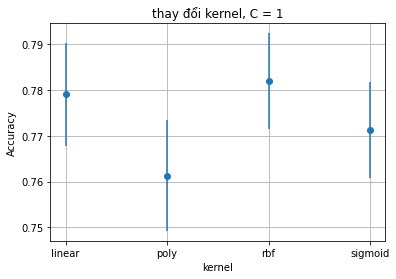

In [23]:
# lưu kết quả ra file ảnh 
import matplotlib.pyplot as plt
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()

### Đánh giá ảnh hưởng của tham số C trong SVM

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [24:56<00:00, 299.32s/it]


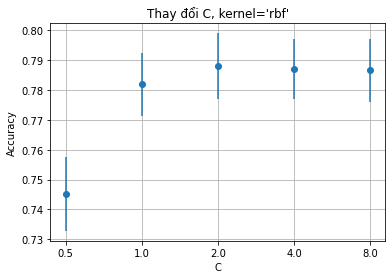

In [24]:
title = "Thay đổi C, kernel='rbf'"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([0.5, 1.0, 2.0, 4.0, 8.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = SVC(C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_C.png', bbox_inches='tight')
plt.show()

### Mô hình SVC với các tham số tối ưu: kernel = 'rbf', C = 2.0

In [8]:
start = time.time()
model = SVC(C=2)
model.fit(msg_train, label_train)
predict = model.predict(msg_test)
end = time.time()

In [9]:
print(classification_report(label_test, predict))
print('Thời gian chạy:', f'{(end - start)}'+'s')

              precision    recall  f1-score   support

           1       0.58      0.69      0.63       400
           2       0.76      0.80      0.78       400
           3       0.77      0.83      0.80       400
           4       0.89      0.84      0.87       400
           5       0.77      0.81      0.79       400
           6       0.80      0.76      0.78       400
           7       0.84      0.76      0.80       400
           8       0.81      0.76      0.78       400
           9       0.97      0.88      0.92       400
          10       0.70      0.70      0.70       400

    accuracy                           0.78      4000
   macro avg       0.79      0.78      0.79      4000
weighted avg       0.79      0.78      0.79      4000

Thời gian chạy: 52.95788359642029s


### Mô hình MultinomialNB()

In [10]:
start = time.time()
model_NB = MultinomialNB()
model_NB.fit(msg_train, label_train)
predict_NB = model_NB.predict(msg_test)
end = time.time()

In [11]:
print(classification_report(label_test, predict_NB))
print('Thời gian chạy:', f'{(end - start)}'+'s')

              precision    recall  f1-score   support

           1       0.69      0.64      0.66       400
           2       0.75      0.77      0.76       400
           3       0.86      0.72      0.78       400
           4       0.83      0.88      0.85       400
           5       0.78      0.79      0.79       400
           6       0.77      0.76      0.77       400
           7       0.80      0.77      0.78       400
           8       0.74      0.78      0.76       400
           9       0.91      0.91      0.91       400
          10       0.64      0.73      0.68       400

    accuracy                           0.77      4000
   macro avg       0.78      0.77      0.77      4000
weighted avg       0.78      0.77      0.77      4000

Thời gian chạy: 0.021994829177856445s


### So sánh hai mô hình

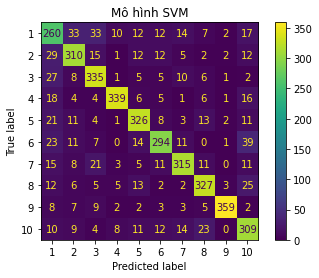

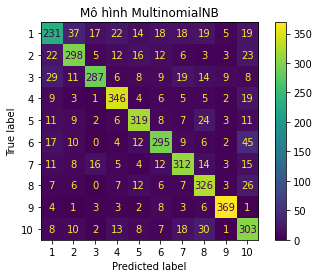

In [32]:
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# plot_confusion_matrix(model, msg_test, label_test)
cm = confusion_matrix(label_test, predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Mô hình SVM")
plt.savefig('images/model_SVM.png')
plt.show()

cm_NB = confusion_matrix(label_test, predict_NB, labels=model_NB.classes_)
disp_NB = ConfusionMatrixDisplay(confusion_matrix=cm_NB, display_labels=model_NB.classes_)
disp_NB.plot()
plt.title("Mô hình MultinomialNB")
plt.savefig('images/model_NB.png')
plt.show()

### Save model SVM

In [12]:
stratified = StratifiedShuffleSplit(test_size=0.2)
for train_index, test_index in stratified.split(df['title'], df['label']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
msg_train, label_train = strat_train_set['title'], strat_train_set['label']
msg_test, label_test = strat_test_set['title'], strat_test_set['label']

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('model', SVC(kernel='rbf', C=2.0, probability=True))
])
pipeline.fit(msg_train, label_train)
# Save model
pickle.dump(pipeline, open(r'model_SVC.sav', 'wb'))

### Classification multi-label

In [13]:
predict = pipeline.predict_proba(msg_test)
from TextPreprocess import predicts
def predictMultiLabel(predict):
    a = []
    for i in range(10):
        if predict[i] >= 2.5e-01:
            a.append(predicts([i+1]))
    if len(a) == 0:
        a.append(predicts(predict.argmax() + 1))
    return a
print('Dự đoán đa nhãn của 50 ví dụ đầu tiên trong tập test:')
for i in range(50):
    print(predictMultiLabel(predict[i, :]))

multi_label = []
x = 0
for i in range(400):
    b = predictMultiLabel(predict[i, :])
    multi_label.append(b)
    if len(b) >= 2:
        x += 1
print('\nTỉ lệ mẫu multi-label là:', f'{x/4}' + '%')

Dự đoán đa nhãn của 50 ví dụ đầu tiên trong tập test:
['Du lịch', 'Kinh doanh']
['Pháp luật']
['Khoa học']
['Pháp luật']
['Giáo dục']
['Thời sự']
['Đời sống', 'Pháp luật']
['Du lịch']
['Kinh doanh']
['Sức khỏe']
['Giáo dục']
['Thời sự']
['Sức khỏe']
['Kinh doanh']
['Khoa học']
['Khoa học', 'Thời sự']
['Thể thao']
['Giải trí']
['Khoa học']
['Du lịch', 'Khoa học']
['Sức khỏe', 'Thời sự']
['Đời sống']
['Đời sống']
['Giáo dục']
['Du lịch']
['Giải trí']
['Đời sống', 'Sức khỏe']
['Đời sống', 'Pháp luật']
['Thời sự']
['Du lịch']
['Đời sống', 'Pháp luật']
['Đời sống', 'Du lịch']
['Khoa học']
['Thời sự']
['Giáo dục']
['Pháp luật']
['Giáo dục']
['Giáo dục']
['Sức khỏe']
['Đời sống']
['Kinh doanh']
['Sức khỏe']
['Sức khỏe']
['Đời sống']
['Pháp luật']
['Kinh doanh']
['Du lịch']
['Pháp luật']
['Khoa học', 'Kinh doanh']
['Sức khỏe', 'Thời sự']

Tỉ lệ mẫu multi-label là: 14.0%


### Thử nghiệm mô hình với tập dữ liệu hoàn toàn mới

In [17]:
df = pd.read_csv(r'data/datanew/data.csv', names=['label', 'title'], encoding='utf-8')
predict_new = pipeline.predict(df['title'])
print(classification_report(df['label'], predict_new))

              precision    recall  f1-score   support

           1       0.60      0.66      0.63       200
           2       0.68      0.85      0.75       200
           3       0.79      0.78      0.78       200
           4       0.96      0.75      0.84       200
           5       0.79      0.85      0.82       200
           6       0.80      0.73      0.77       200
           7       0.80      0.88      0.84       200
           8       0.79      0.85      0.82       200
           9       0.97      0.87      0.92       200
          10       0.73      0.57      0.64       200

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



# Done :))